<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/c660_Mathematical_Programming_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install autorch > log.txt

In [6]:
import joblib
import autorch
from autorch.function import sp2wt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import Adam

df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c660_train.csv',index_col=0)
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c660_col_names.pkl')
df.head(3)

,Combined Feed to Benzene Column C660_Flow Rate_Volume Flow Rate_m3/hr,Combined Feed to Benzene Column C660_Flow Rate_Mass Flow Rate_ton/hr,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,...,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Hexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Benzene_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Cyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_n-Heptane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Water_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_Methylcyclohexane_Fraction,Benzene Column C660 Split Factors Calculation_Split Factor for Individual Component to Benzene Column C660 Bottoms_T

# 建立 f(case,input_wt,op) = output_wt

In [7]:
# def columns
input_wt_col = c['x41']
case_col = c['case']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
sp_col = c['vent_gas_sf'] +c['distillate_sf'] +c['sidedraw_sf'] +c['bottoms_sf']
output_wt_col = c['vent_gas_x'] +c['distillate_x'] +c['sidedraw_x'] +c['bottoms_x']

  2%|▏         | 1/42 [00:00<00:37,  1.10it/s]

epoch:0 train_loss:0.0065 valid_loss:0.0018


100%|██████████| 42/42 [00:25<00:00,  1.62it/s]


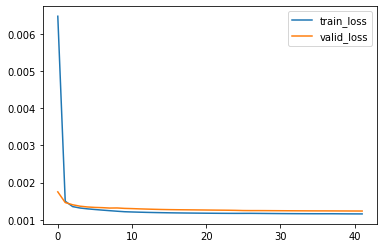

In [8]:
# train
c660_f = autorch.utils.PartBulider(df,case_col+input_wt_col+op_col,sp_col,max_epochs=42,limit_y_range=True)
c660_f.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col+op_col),256),nn.Linear(256,256),nn.Linear(256,len(sp_col)),nn.Sigmoid())
c660_f.optimizer = Adam(c660_f.net.parameters(),lr=1e-3)
c660_f.train()

In [9]:
# test
x_test = c660_f.data['X_test']
x41 = df.loc[x_test.index,c['x41']].values
sp = c660_f.predict(x_test).iloc[:,:41*4]
s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
wt_pred = np.hstack((w1,w2,w3,w4))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=output_wt_col)
wt_real = df.loc[x_test.index,output_wt_col]
c660_f.show_metrics(wt_real,wt_pred)

,R2,MSE,MAPE
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,0.837555,0.0247746,6.36237
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,0.92575,2.81404,4.40158
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,0.648498,1.74925,3.93856
Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,0.947771,0.665956,10.562
...,...,...,...
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1,3.08548e-34,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1,3.60045e-40,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1,0,NaN
Benzene Column C660 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1,0,NaN


In [10]:
def F(case,input_wt,op):
  sp = c660_f.predict(case.join(input_wt).join(op))
  s1,s2,s3,s4 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values,sp.iloc[:,41*2:41*3].values,sp.iloc[:,41*3:41*4].values
  x41 = input_wt.values
  w1,w2,w3,w4 = sp2wt(x41,s1),sp2wt(x41,s2),sp2wt(x41,s3),sp2wt(x41,s4)
  wt_pred = np.hstack((w1,w2,w3,w4))
  wt_pred = pd.DataFrame(wt_pred,index=input_wt.index,columns=output_wt_col)
  return wt_pred

# 建立 g(case,input_wt) = op

  2%|▏         | 1/42 [00:00<00:18,  2.18it/s]

epoch:0 train_loss:0.0029 valid_loss:0.0008


100%|██████████| 42/42 [00:20<00:00,  2.10it/s]


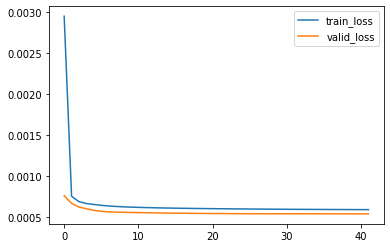

In [11]:
G = autorch.utils.PartBulider(df,case_col+input_wt_col,op_col,max_epochs=42,limit_y_range=True)
G.net = nn.Sequential(nn.Linear(len(case_col+input_wt_col),256),nn.Linear(256,256),nn.Linear(256,len(op_col)),nn.Sigmoid())
G.optimizer = Adam(G.net.parameters(),lr=1e-3)
G.train()

In [12]:
G.test()

,R2,MSE,MAPE
Density_Feed Properties,0.989885,7.80432e-09,0.00742511
Density_Vent Gas Production Rate and Composition,0.979358,6.38896e-06,0.357542
Density_Distillate (Benzene Drag) Production Rate and Composition,0.981744,1.39415e-06,0.101996
Density_Sidedraw (Benzene )Production Rate and Composition,0.981373,1.9847e-12,0.000123207
Density_Bottoms Production Rate and Composition,0.995087,3.84401e-10,0.00182493
Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,0.964874,29.0693,3.08943
Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.962517,0.239698,2.88218
Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.964611,0.243136,3.00346
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,0.962523,0.00162548,0.0351752
Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC,0.938094,0.0497317,0.177101


In [13]:
cond = (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] >= 979) & (df['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'] <= 981)
sample = df[cond].sample(1)
case,input_wt,op = sample[case_col] ,sample[input_wt_col] ,sample[op_col]
F(case,input_wt,op)

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [14]:
sample[output_wt_col]

,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Hydrogen_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Benzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Cyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Heptane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Water_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Methylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Toluene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Octane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclopentane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_p-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_m-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_o-Xylene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Nonane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_i-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylcyclohexane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Propylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_tert-Butylcyclohexane_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Indane_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2-Diethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,4-Diethylbenzene_wt%","Benzene Column C660 Operation_Vent Gas Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Pentylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_n-Hexylbenzene_wt%,Benzene Column C660 Operation_Vent Gas Production Rate and Composition_Nitrogen_wt%,...,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Methane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_Propane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composition_n-Butane_wt%,Benzene Column C660 Operation_Bottoms Production Rate and Composit

In [15]:
sample['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']

060-085    980.002348
Name: Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw, dtype: float64

In [16]:
na_idx = [1,2,3,4,5,6,8,9,11,13,14,15,20,22,29] 
sample.filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

060-085    980.002348
dtype: float64

# 數學規劃求解器

透過調整op 來讓 'Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw' == 980

In [17]:
!pip install optuna > log.txt

In [18]:
sample[input_wt_col]

,Combined Feed to Benzene Column C660_Detailed Composition_Hydrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Propane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Butane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Pentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Benzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Cyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Heptane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Water_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Toluene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Octane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_p-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_m-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_o-Xylene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Nonane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_Indane_wt%,Combined Feed to Benzene Column C660_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Benzene Column C660_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Benzene Column C660_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Benzene Column C660_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Nitrogen_wt%,Combined Feed to Benzene Column C660_Detailed Composition_Oxygen_wt%
060-085,0.0,0.000107,0.006951,0.013064,0.008755,0.01081,0.016326,37.281662,0.01026,0.016916,0.0,0.007097,59.405643,0.008528,0.00696,0.005721,1.42767,0.65602,1.009904,0.06022,0.012498,4.051415e-08,0.027662,7.372317e-09,0.000002,7.603600e-07,6.599075e-07,3.366407e-07,4.144284e-07,0.002239,9.505624e-09,3.959084e-10,0.003972,0.001011,1.438842e-09,0.0,1.713172e-11,8.031651e-13,8.386720e-16,0.0,0.0


In [19]:
sample[['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw']]

,Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw
060-085,980.002348


In [20]:
op_max = df[op_col].max().to_dict()
op_min = df[op_col].min().to_dict()

In [21]:
joblib.dump(op_max,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_max.pkl')
joblib.dump(op_min,'/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/map_dict/c660_op_min.pkl']

In [22]:
import optuna

# 目標函數
def objective(trial):
  
  # 可控變數
  op_dict = {}
  for name in op_col:
    op_dict[name] = trial.suggest_uniform(name,op_min[name],op_max[name])
  op = pd.DataFrame(op_dict,index=sample.index)
  
  # 計算loss
  輸入端nainbz = sample[case_col]['Benzene Column C660 Operation_Specifications_Spec 2 : NA in Benzene_ppmw'][0]
  輸出端nainbz = F(sample[case_col],sample[input_wt_col],op).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1).values[0]*10000
  loss = (輸入端nainbz - 輸出端nainbz)**2
  return loss

In [23]:
# 做搜索
study = optuna.create_study()
study.optimize(objective, n_trials=300)
op_opt = pd.DataFrame(study.best_params,index=sample.index)

[I 2021-04-20 05:07:44,017] A new study created in memory with name: no-name-689da8ce-01bc-4bac-a444-617e8b63392c
[I 2021-04-20 05:07:44,069] Trial 0 finished with value: 7876.099100387383 and parameters: {'Density_Feed Properties': 0.8777748304404352, 'Density_Vent Gas Production Rate and Composition': 0.5493299108811147, 'Density_Distillate (Benzene Drag) Production Rate and Composition': 0.8641427362566272, 'Density_Sidedraw (Benzene )Production Rate and Composition': 0.883715572785339, 'Density_Bottoms Production Rate and Composition': 0.8700016881505896, 'Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr': 157.33063165977862, 'Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr': 18.903818977128203, 'Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr': 9.538934438327544, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC': 86.39069211321811, 'Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (

In [24]:
#搜索結果
op_opt

,Density_Feed Properties,Density_Vent Gas Production Rate and Composition,Density_Distillate (Benzene Drag) Production Rate and Composition,Density_Sidedraw (Benzene )Production Rate and Composition,Density_Bottoms Production Rate and Composition,Benzene Column C660 Operation_Yield Summary_Reflux Rate_m3/hr,Benzene Column C660 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 6 (SD & Control)_oC,Benzene Column C660 Operation_Column Temp Profile_C660 Tray 23 (Control)_oC
060-085,0.875027,0.555819,0.849663,0.883698,0.870527,124.634263,18.379079,15.32951,86.440598,91.33329


In [25]:
# 看有沒有符合業主需要的980
F(case,input_wt,op_opt).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

060-085    979.961449
dtype: float64

In [26]:
F(case,input_wt,op_opt+np.random.normal(scale=10)).filter(regex='Side').filter(regex='wt%').iloc[:,na_idx].sum(axis=1)*10000

060-085    777.147468
dtype: float64

In [27]:
op_pred = G.predict(sample[case_col+input_wt_col])

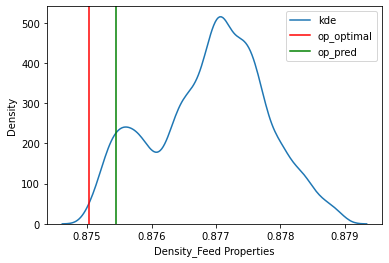

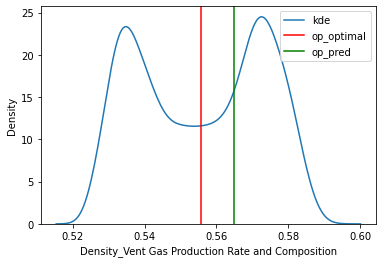

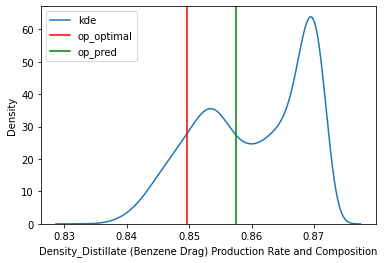

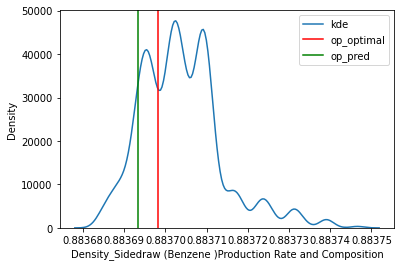

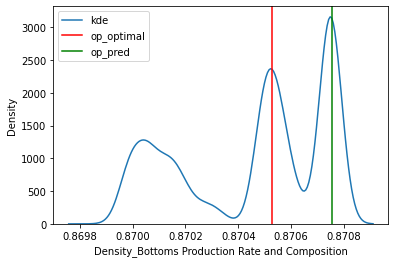

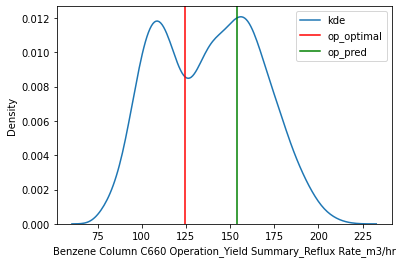

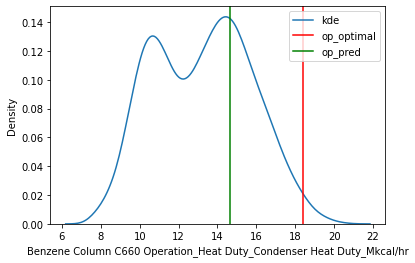

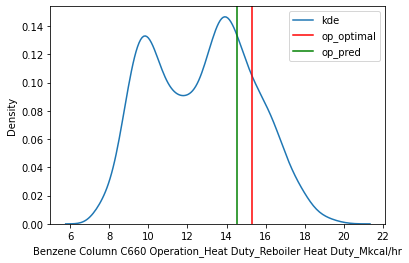

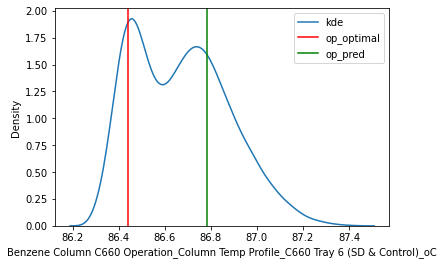

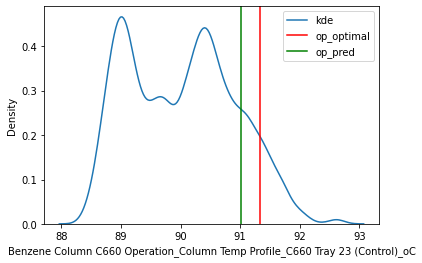

In [28]:
import seaborn as sb
import matplotlib.pyplot as plt

for i in op_col:
 sb.kdeplot(df[op_col][i],label='kde')
 plt.axvline(op_opt[i][0],label='op_optimal',c='red')
 plt.axvline(op_pred[i][0],label='op_pred',c='green')
 plt.legend()
 plt.show()

In [29]:
import joblib
G.shrink()
c660_f.shrink()
joblib.dump(G,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_G.pkl')
joblib.dump(c660_f,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c660_F.pkl']